In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import math

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms,datasets
from dataset_wrapper import get_pet_datasets
## Imports for plotting
import matplotlib.pyplot as plt

In [3]:
batch_size = 4
img_h = 128;

transform = transforms.Compose([transforms.ToTensor()])

train_dataset, val_dataset, test_dataset = get_pet_datasets(img_width=img_h, img_height=img_h,root_path='./data' )

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

#selecting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#printing because my main kernel wants to be stuck on CPU-only pytorch fsr
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

# When iteration starts, queue and thread start to load data from files.
data_iter = iter(train_loader)
# Mini-batch images and labels.
images_onebatch, labels = next(data_iter)
print(images_onebatch.shape)

GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
torch.Size([4, 3, 128, 128])


In [4]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.register_buffer('pos_embedding', get_sinusoidal_positional_embedding(1 + num_patches, embed_dim))#fixed position embedding 
        # self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim)) # learnable positional embedding


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, C, Ph, Pw = x.shape
        x = x.flatten(2,4)  # # Flatten channel and patch spatial dimensions(2-4) (C, patch_H, patch_W) -> (C * patch_H * patch_W)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding, summary token, the classification model will learn this token's attention on the entire sequence
        cls_token = self.cls_token.repeat(B, 1, 1) # A learnable parameter
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.pos_embedding[:,:T+1] # CLS Token need positinal embedding

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [5]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim), #expansion to four folder
            nn.GELU(), # Gaussian Error Linear Units (GELUs)
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim), #reduce the dimensionality back
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [6]:
import numpy as np
def get_sinusoidal_positional_embedding(n_positions, dim):
    position = torch.arange(n_positions).unsqueeze(1)        # (n_positions, 1)
    div_term = torch.exp(torch.arange(0, dim, 2) * (-np.log(10000.0) / dim))  # (dim/2,) #Avoids overflow/underflow in exp(log) way
    
    pe = torch.zeros(n_positions, dim)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe.unsqueeze(0)  # shape: (1, n_positions, dim)


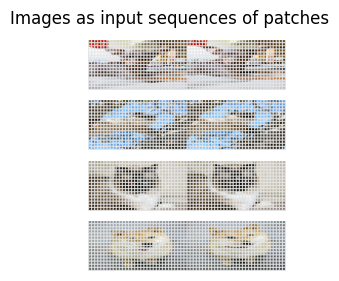

In [7]:
def img_to_patch(x, patch_size):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)#[B, C, H', p_H, W',p_W]
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    return x

img_patches = img_to_patch(images_onebatch, patch_size=4)# CIFAR10 images are 32x32

fig, ax = plt.subplots(images_onebatch.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(images_onebatch.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [10]:
embed_dim = 128
hidden_dim = 256
num_channels = 3
num_heads = 4
num_layers = 6
num_classes = 4 #we have 4 classes
patch_size = 4
num_patches = (128//patch_size)*(128//patch_size)  #img is 128x128

learning_rate = 0.001
num_epochs = 25  #often trained for 300–500 epochs 

model = VisionTransformer(embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # Feel free to use other loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Feel free to try other optimizer, e,g,SGD (Stochastic Gradient Descent), Adagrad

# --- Train the model ---
total_step = len(train_loader)
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')


Epoch [1/25], Step [100/1430], Loss: 1.0159
Epoch [1/25], Step [200/1430], Loss: 1.3093
Epoch [1/25], Step [300/1430], Loss: 1.1801
Epoch [1/25], Step [400/1430], Loss: 1.7826
Epoch [1/25], Step [500/1430], Loss: 1.5861
Epoch [1/25], Step [600/1430], Loss: 1.3248
Epoch [1/25], Step [700/1430], Loss: 1.5159
Epoch [1/25], Step [800/1430], Loss: 1.1499
Epoch [1/25], Step [900/1430], Loss: 1.2204
Epoch [1/25], Step [1000/1430], Loss: 1.3140
Epoch [1/25], Step [1100/1430], Loss: 1.1027
Epoch [1/25], Step [1200/1430], Loss: 1.0869
Epoch [1/25], Step [1300/1430], Loss: 1.3086
Epoch [1/25], Step [1400/1430], Loss: 1.2171
Epoch [2/25], Step [100/1430], Loss: 1.6300
Epoch [2/25], Step [200/1430], Loss: 1.2491
Epoch [2/25], Step [300/1430], Loss: 1.1631
Epoch [2/25], Step [400/1430], Loss: 1.2542
Epoch [2/25], Step [500/1430], Loss: 1.1238
Epoch [2/25], Step [600/1430], Loss: 1.2750
Epoch [2/25], Step [700/1430], Loss: 1.1091
Epoch [2/25], Step [800/1430], Loss: 1.7224
Epoch [2/25], Step [900/143

In [11]:
# --- Test the model ---
model.eval()  # evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)# choose the class that have the highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
    #Remember guessing randomly among 10 classes would be about 10% accuracy

# --- Save the model checkpoint ---
torch.save(model.state_dict(), 'vit_model.ckpt')

Test Accuracy of the model on the 10000 test images: 41.06145251396648 %
